## Imports

In [25]:
import torch
import torchvision
import torch.nn as nn

import torchvision.datasets

import torchvision.transforms as tforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm as tqdm

## Data preparation

In [26]:

channels = 3
im_size = 16

mnist_transform = tforms.Compose([
        tforms.Resize(im_size),
        tforms.ToTensor(),
        tforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
        tforms.Normalize([0.5],[0.5])
    ])

train_0 = torchvision.datasets.MNIST(root="./data", train=True, transform=mnist_transform, download=True)
test_regular_mnist = torchvision.datasets.MNIST(root="./data", train=False, transform=mnist_transform, download=True)

def random_color(im):
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

colored_transform = tforms.Compose([
    tforms.Resize(im_size),
    tforms.ToTensor(),
    random_color,
    tforms.Normalize([0.5],[0.5])
])

train_1 = torchvision.datasets.MNIST(root="./data", train=True, transform=colored_transform, download=True)
test_colored_mnist = torchvision.datasets.MNIST(root="./data", train=False, transform=colored_transform, download=True)


In [68]:
def display_cond_generation(model, x_0):
    model.euler_dt = 1e-2
    x_1 = model.sample(x_0)
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    ax[0].imshow(x_0[0].permute([1, 2, 0]).cpu())
    
    ax[1].imshow(x_1[0].permute([1, 2, 0]).cpu())
    


## Model

In [44]:
from unet import UNet

class FlowMathcing(nn.Module):
    def __init__(self, unet):
        super().__init__()
        # CNN + positional embeding time conditioning
        # can use NN from MNIST DDPM
        self.vector_net = UNet(channels, base_channels=128, channel_mults=(1, 2, 4))
        self.vector_net = unet
        self.euler_dt = 0.01
        
    
    def forward(self, x_0):
        # solve forward ODE via Euler or torchdiffeq solver
        x_t = x_0
        
        t_range = tqdm(torch.arange(0, 1, step=self.euler_dt))
        
        for t in t_range:
            x_t = x_t + self.vector_net(x_t, t) * self.euler_dt
            
        return x_t

    @torch.no_grad()
    def sample(self, x_0):
        x_t = x_0
        dt = 0.001
        
        t_range = tqdm(torch.arange(0, 1, step=self.euler_dt))
        
        for t in t_range:
            x_t = x_t + self.vector_net(x_t, t) * self.euler_dt
            
        return x_t
    
    def step(self, x_0, x_1, t):
        t = t.reshape([-1, 1, 1, 1])
        x_t = t * x_1 + (1 - t) * x_0
        x_t_hat = self.vector_net(x_t, t)
        return self.loss(x_t_hat, x_0, x_1, t).mean()
    
    def loss(self, x_t_hat, x_0, x_1, t):
        return torch.norm((x_t_hat - (x_1 - x_0)).reshape([x_0.shape[0], -1]), dim=-1)
    

In [29]:
model_unet = UNet(channels, base_channels=128, channel_mults=(1, 2, 4))

train_colored_mnist_loader = torch.utils.data.DataLoader(train_colored_mnist, batch_size=64, shuffle=True)

samples_input = next(iter(train_colored_mnist_loader))[0]

model_unet(samples_input, torch.zeros([64])).shape

NameError: name 'train_colored_mnist' is not defined

In [ ]:
# fm_model = FlowMathcing()
with torch.no_grad():
    sample_output = fm_model(sample_regular_mnist.to('cuda:1'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


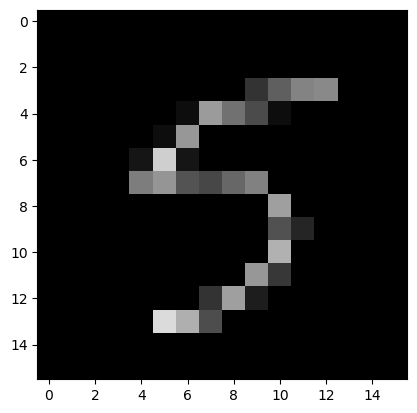

In [40]:
plt.imshow(sample_regular_mnist[15].detach().cpu().permute([1, 2, 0]), cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


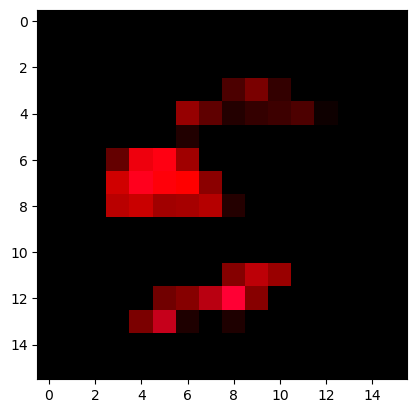

In [41]:
plt.imshow(sample_output[15].detach().cpu().permute([1, 2, 0]), cmap='gray')

## Training

In [30]:
device = 'cuda:1'
batch_size = 64
epochs = 10

train_colored_mnist_loader = torch.utils.data.DataLoader(train_1, batch_size=batch_size, shuffle=True, drop_last=True)
train_regular_mnist_loader = torch.utils.data.DataLoader(train_0, batch_size=batch_size, shuffle=True, drop_last=True)

unet_mnist = UNet(channels, base_channels=128, channel_mults=(1, 2, 4))

fm_model = FlowMathcing(unet_mnist)
# fm_model.load_state_dict(torch.load('fm_model_colored_mnist_16.pth'))

fm_model.to(device)

opt = torch.optim.AdamW(fm_model.parameters(), lr=3e-4)

from optimal_transport import OTPlanSampler

def create_pairs_OT(batch_x_0, batch_x_1):
    ot_sampler = OTPlanSampler(method="exact")
    x0, x1 = ot_sampler.sample_plan(batch_x_0, batch_x_1)
    return x0, x1

sample_regular_mnist = next(iter(train_regular_mnist_loader))[0]
sample_colored_mnist = next(iter(train_colored_mnist_loader))[0]


In [31]:
pbar = tqdm(enumerate(zip(iter(train_regular_mnist_loader), iter(train_colored_mnist_loader))))
n_epochs = 30
loss_storage = []

for epoch in range(n_epochs):
    for itr, item in enumerate(zip(iter(train_regular_mnist_loader), iter(train_colored_mnist_loader))):
    #     print(item)[0]
        ((x_0, y_0), (x_1, y_1)) = item
        x_0, x_1 = x_0.to(device), x_1.to(device)
        x0, x1 = create_pairs_OT(x_0, x_1)
        t = torch.rand(batch_size).to(device)
        loss = fm_model.step(x_0, x_1, t)

        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_storage.append(loss.item())
        if itr % 100 == 0:
            print(f'Epoch: {epoch} iter {itr} Loss {torch.mean(torch.tensor(loss_storage[-min(1000, len(loss_storage)):]))}')
    #     pbar.set_description(f'Loss: {loss.item()}')
    torch.save(fm_model.state_dict(), f'fm_model_mnist_16_ep_{epoch}.pth')




0it [20:14:37, ?it/s]


Epoch: 0 iter 0 Loss 16.828414916992188
Epoch: 0 iter 100 Loss 10.85605239868164
Epoch: 0 iter 200 Loss 8.564728736877441
Epoch: 0 iter 300 Loss 7.440168380737305
Epoch: 0 iter 400 Loss 6.715147018432617
Epoch: 0 iter 500 Loss 6.1765217781066895
Epoch: 0 iter 600 Loss 5.728676795959473
Epoch: 0 iter 700 Loss 5.386662483215332
Epoch: 0 iter 800 Loss 5.1011457443237305
Epoch: 0 iter 900 Loss 4.858580112457275
Epoch: 1 iter 0 Loss 4.775923252105713
Epoch: 1 iter 100 Loss 4.242400169372559
Epoch: 1 iter 200 Loss 3.683765411376953
Epoch: 1 iter 300 Loss 3.359555721282959
Epoch: 1 iter 400 Loss 3.1146011352539062
Epoch: 1 iter 500 Loss 2.9273641109466553
Epoch: 1 iter 600 Loss 2.7756383419036865
Epoch: 1 iter 700 Loss 2.661888599395752
Epoch: 1 iter 800 Loss 2.5706067085266113
Epoch: 1 iter 900 Loss 2.4824483394622803
Epoch: 2 iter 0 Loss 2.454749822616577
Epoch: 2 iter 100 Loss 2.4000189304351807
Epoch: 2 iter 200 Loss 2.33496356010437
Epoch: 2 iter 300 Loss 2.275063991546631
Epoch: 2 iter 

Epoch: 19 iter 600 Loss 1.0272690057754517
Epoch: 19 iter 700 Loss 1.0256543159484863
Epoch: 19 iter 800 Loss 1.0217305421829224
Epoch: 19 iter 900 Loss 1.0219866037368774
Epoch: 20 iter 0 Loss 1.0187902450561523
Epoch: 20 iter 100 Loss 1.014991283416748
Epoch: 20 iter 200 Loss 1.0085104703903198
Epoch: 20 iter 300 Loss 1.0071125030517578
Epoch: 20 iter 400 Loss 1.0017415285110474
Epoch: 20 iter 500 Loss 1.0065598487854004
Epoch: 20 iter 600 Loss 1.000998616218567
Epoch: 20 iter 700 Loss 0.9961105585098267
Epoch: 20 iter 800 Loss 0.9917536377906799
Epoch: 20 iter 900 Loss 0.9891328811645508
Epoch: 21 iter 0 Loss 0.9867513179779053
Epoch: 21 iter 100 Loss 0.9847549200057983
Epoch: 21 iter 200 Loss 0.9890188574790955
Epoch: 21 iter 300 Loss 0.9873193502426147
Epoch: 21 iter 400 Loss 0.9889514446258545
Epoch: 21 iter 500 Loss 0.9898549318313599
Epoch: 21 iter 600 Loss 0.9886007905006409
Epoch: 21 iter 700 Loss 0.9901310205459595
Epoch: 21 iter 800 Loss 0.9927894473075867
Epoch: 21 iter 90

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.55it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


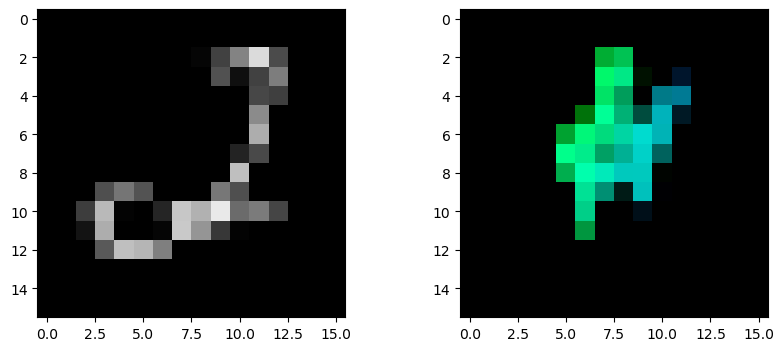

In [53]:

sample_regular_mnist = next(iter(train_regular_mnist_loader))[0]
display_cond_generation(fm_model, sample_regular_mnist.to(device))

In [79]:

unet_cifar = UNet(channels, base_channels=128, channel_mults=(1, 2, 4, 8))

fm_model_cifar = FlowMathcing(unet_cifar)
# fm_model.load_state_dict(torch.load('fm_model_colored_mnist_16.pth'))

fm_model_cifar.to(device)

opt_cifar = torch.optim.AdamW(fm_model_cifar.parameters(), lr=1e-4)

In [80]:
from utils import unpaint_center


def unpaint_center(images, mask_size=0.5):
    img_size = images.shape[-1]
    mask = torch.ones_like(images)
    mask[:, :, int(mask_size / 2 * img_size):img_size - int(mask_size / 2 * img_size), int(mask_size / 2 * img_size):img_size - int(mask_size / 2 * img_size)] = 0
    return torch.mul(images, mask)

transform = tforms.Compose(
    [tforms.ToTensor(),
     tforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=batch_size,
                                          shuffle=True, num_workers=2, drop_last=True)

n_epochs = 30
loss_storage = []

for epoch in range(n_epochs):
    for itr, item in enumerate(iter(trainloader_cifar)):
        x_1, y = item
        x_0 = unpaint_center(x_1)
        x_0, x_1 = x_0.to(device), x_1.to(device)
#         x0, x1 = create_pairs_OT(x_0, x_1)
        t = torch.rand(batch_size).to(device)
        loss = fm_model_cifar.step(x_0, x_1, t)

        opt_cifar.zero_grad()
        loss.backward()
        opt_cifar.step()
        loss_storage.append(loss.item())
        if itr % 100 == 0:
            print(f'Epoch: {epoch} iter {itr} Loss {torch.mean(torch.tensor(loss_storage[-min(1000, len(loss_storage)):]))}')
    #     pbar.set_description(f'Loss: {loss.item()}')
    torch.save(fm_model.state_dict(), f'fm_model_cifar_32_ep_{epoch}.pth')


Files already downloaded and verified
Epoch: 0 iter 0 Loss 23.77988052368164
Epoch: 0 iter 100 Loss 10.396723747253418
Epoch: 0 iter 200 Loss 7.894082069396973
Epoch: 0 iter 300 Loss 6.6403985023498535
Epoch: 0 iter 400 Loss 5.850844860076904
Epoch: 0 iter 500 Loss 5.296468257904053
Epoch: 0 iter 600 Loss 4.885606288909912
Epoch: 0 iter 700 Loss 4.5547685623168945
Epoch: 1 iter 0 Loss 4.3361358642578125
Epoch: 1 iter 100 Loss 4.1055073738098145
Epoch: 1 iter 200 Loss 3.910879135131836
Epoch: 1 iter 300 Loss 3.1416141986846924
Epoch: 1 iter 400 Loss 2.7618536949157715
Epoch: 1 iter 500 Loss 2.527355909347534
Epoch: 1 iter 600 Loss 2.360628366470337
Epoch: 1 iter 700 Loss 2.227752447128296
Epoch: 2 iter 0 Loss 2.1385388374328613
Epoch: 2 iter 100 Loss 2.045454978942871
Epoch: 2 iter 200 Loss 1.9667460918426514
Epoch: 2 iter 300 Loss 1.8916950225830078
Epoch: 2 iter 400 Loss 1.8320146799087524
Epoch: 2 iter 500 Loss 1.7668131589889526
Epoch: 2 iter 600 Loss 1.7250927686691284
Epoch: 2 ite

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


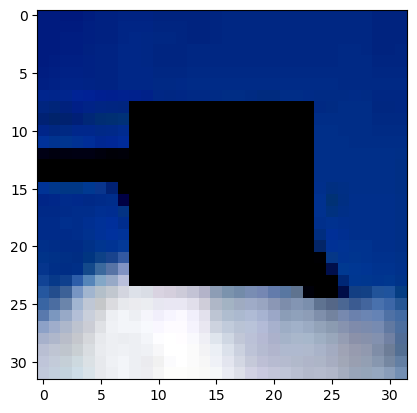

In [77]:
plt.imshow(unpaint_center(next(iter(trainloader_cifar))[0])[0].permute([1, 2, 0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


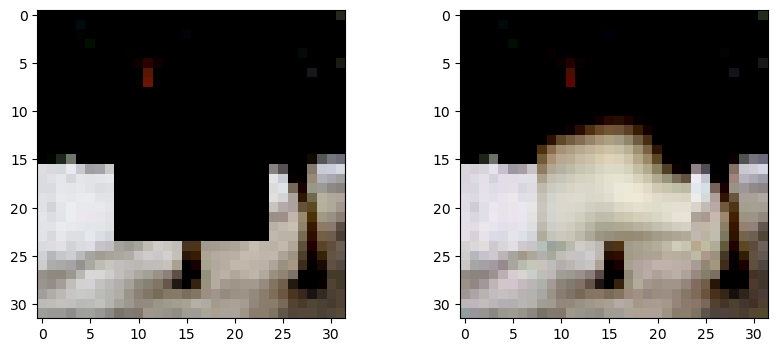

In [85]:
fm_model.load_state_dict(torch.load('fm_model_cifar_32_ep_2.pth'))
sample_regular_mnist = unpaint_center(next(iter(trainloader_cifar))[0])
display_cond_generation(fm_model_cifar, sample_regular_mnist.to(device))